# Part 8 - Random Forests & XGBoost

**By Aziz Presswala**

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from prettytable import PrettyTable
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import model_selection
from sklearn import metrics
from xgboost import XGBClassifier
from gensim.models import Word2Vec

### [1.0] Splitting the Dataset into Train & Test

In [2]:
# Using the CleanedText column saved in final.sqlite db
con = sqlite3.connect('final.sqlite')
filtered_data = pd.read_sql_query("SELECT * FROM Reviews", con)
filtered_data.shape

(364171, 12)

In [3]:
# replacing all the 'positive' values of the Score attribute with 1
filtered_data['Score']=filtered_data['Score'].replace('positive',1)

In [4]:
# replacing all the 'neagtive' values of the Score attribute with 0
filtered_data['Score']=filtered_data['Score'].replace('negative',0)

In [5]:
#randomly selecting 50k points from the dataset
df=filtered_data.sample(50000)

In [6]:
#sort the dataset by timestamp
df = df.sort_values('Time')
#splitting the dataset into train(70%) & test(30%)
train_data = df[0:35000]
test_data = df[35000:50000]

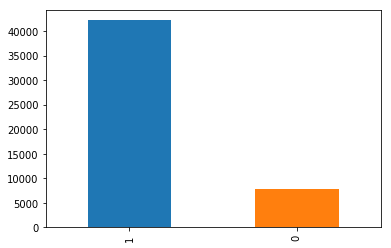

In [7]:
# distribution of output variable
df['Score'].value_counts().plot.bar()

## [2.0] Featurization

### BAG OF WORDS

In [8]:
#applying fit transform on train datasset
count_vect = CountVectorizer(min_df=10)
x_train_bow = count_vect.fit_transform(train_data['CleanedText'].values)
x_train_bow.shape

(35000, 5251)

In [9]:
#applying transform on test dataset
x_test_bow = count_vect.transform(test_data['CleanedText'].values)
x_test_bow.shape

(15000, 5251)

In [10]:
y_train_bow = train_data['Score']
y_test_bow = test_data['Score']

### TF-IDF

In [11]:
#applying fit transform on train datasset
tf_idf_vect = TfidfVectorizer(min_df=10)
x_train_tfidf = tf_idf_vect.fit_transform(train_data['CleanedText'].values)
x_train_tfidf.shape

(35000, 5251)

In [12]:
#applying transform on test dataset
x_test_tfidf = tf_idf_vect.transform(test_data['CleanedText'].values)
x_test_tfidf.shape

(15000, 5251)

In [13]:
y_train_tfidf = train_data['Score']
y_test_tfidf = test_data['Score']

### Avg. Word2Vec

In [33]:
#training Word2Vec Model for train dataset
i=0
list_of_sent=[]
for sent in train_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [34]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [35]:
X = w2v_model[w2v_model.wv.vocab]

In [36]:
#computing Avg Word2Vec for train dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [00:55<00:00, 634.85it/s]


35000
50


In [37]:
x_train_w2v = np.array(sent_vectors)
y_train_w2v = train_data['Score']
x_train_w2v.shape

(35000, 50)

In [38]:
#training Word2Vec Model for test dataset
i=0
list_of_sent1=[]
for sent in test_data['CleanedText'].values:
    list_of_sent1.append(sent.split())

In [39]:
#computing Avg Word2Vec for test dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:31<00:00, 477.84it/s]


15000
50


In [40]:
x_test_w2v = np.array(sent_vectors)
y_test_w2v = test_data['Score']
x_test_w2v.shape

(15000, 50)

### TFIDF - Word2Vec

In [51]:
# training model for training data
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(train_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [52]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [01:10<00:00, 493.94it/s]


In [53]:
x_train_tfw2v = np.array(tfidf_sent_vectors)
y_train_tfw2v = train_data['Score']
x_train_tfw2v.shape

(35000, 50)

In [54]:
# training model for test dataset
tf_idf_matrix = model.fit_transform(test_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [55]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:40<00:00, 370.20it/s]


In [56]:
x_test_tfw2v = np.array(tfidf_sent_vectors)
y_test_tfw2v = test_data['Score']
x_test_tfw2v.shape

(15000, 50)

## [3.1] Applying RF

### [3.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [21]:
# initializing RandomForestClassifier model
RFC = RandomForestClassifier(class_weight='balanced')

# hyperparameter values we need to try on classifier
max_depth = [10, 30, 50, 70, 90, 100]
n_estimators = [50, 100, 200, 300, 400, 500]
param_grid = {'max_depth': max_depth,
              'n_estimators': n_estimators}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 3 fold CV
gscv = GridSearchCV(RFC, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)

gscv.fit(x_train_bow,y_train_bow)
print("Best Max Depth Value:",gscv.best_params_['max_depth'])
print("Best No. of Estimators:",gscv.best_params_['n_estimators'])
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best Max Depth Value: 100
Best No. of Estimators: 500
Best ROC AUC Score: 0.91873


In [22]:
# determining optimal depth and base learners
optimal_depth = gscv.best_params_['max_depth']
optimal_estimators = gscv.best_params_['n_estimators']

#training the model using the optimal hyperparameters
RFC_clf = RandomForestClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators)
RFC_clf.fit(x_train_bow,y_train_bow)

#predicting the class label using test data 
y_pred = RFC_clf.predict_proba(x_test_bow)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_bow, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.901450 ****


**Seaborn Heatmap on Train Data**

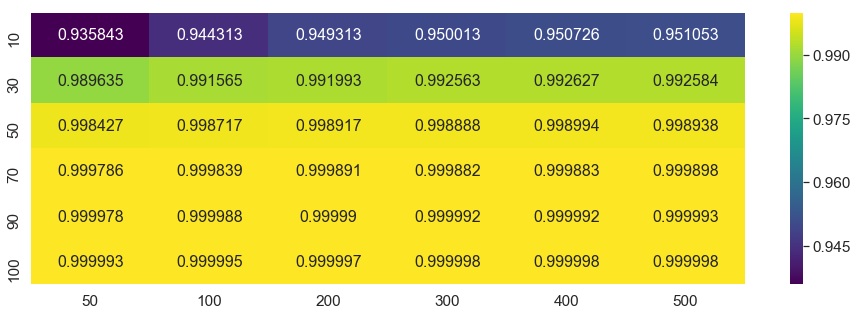

In [25]:
A = np.array(gscv.cv_results_['mean_train_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Seaborn Heatmap on Test Data**

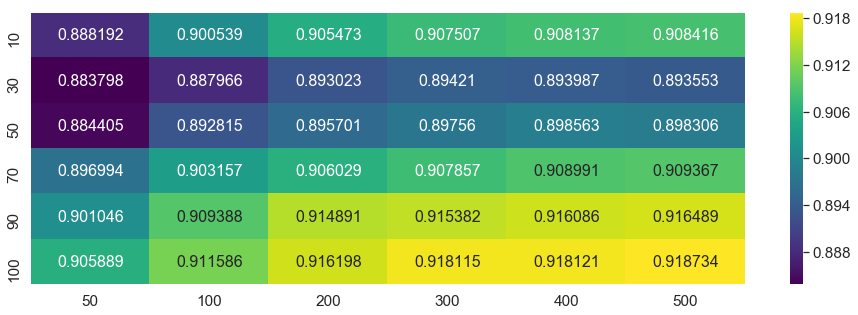

In [26]:
A = np.array(gscv.cv_results_['mean_test_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**ROC Curve**

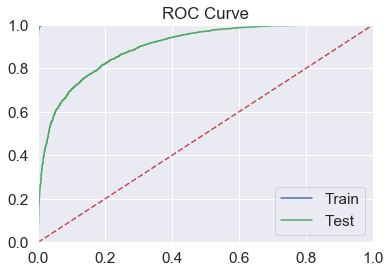

In [27]:
# Plotting roc curve on Train Data
pred_train = RFC_clf.predict_proba(x_train_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_train_bow, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = RFC_clf.predict_proba(x_test_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_test_bow, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[  647  2015]
 [   32 12306]]


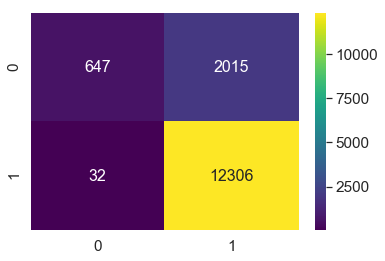

In [23]:
# plotting confusion matrix as heatmap
y_predict = RFC_clf.predict(x_test_bow)
cm = confusion_matrix(y_test_bow, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**Confusion Matrix on Train Data**

[[ 4481   688]
 [    0 29831]]


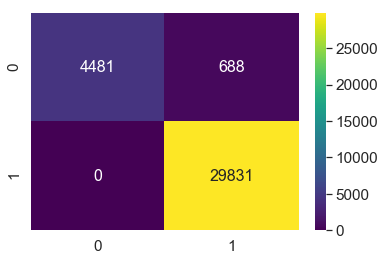

In [28]:
# plotting confusion matrix as heatmap
y_predict = RFC_clf.predict(x_train_bow)
cm = confusion_matrix(y_train_bow, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

### [3.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [29]:
# Calculate feature importances from decision trees
importances = RFC_clf.feature_importances_

# Sort feature importances in descending order and get their indices
indices = np.argsort(importances)[::-1][:30]

# Get the feature names from the vectorizer
names = count_vect.get_feature_names()
names = np.array(names)
words = names[indices]
words

array(['disappoint', 'great', 'love', 'return', 'wast', 'worst', 'money',
       'aw', 'horribl', 'terribl', 'best', 'tast', 'would', 'bad',
       'thought', 'threw', 'good', 'refund', 'delici', 'disgust',
       'product', 'receiv', 'like', 'descript', 'didnt', 'stale',
       'perfect', 'one', 'away', 'unfortun'], dtype='<U14')

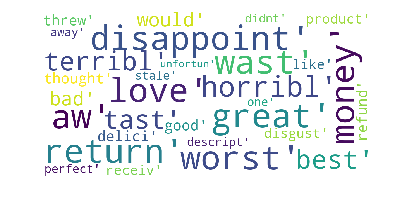

In [30]:
wordcloud = WordCloud(background_color='white',
                      max_font_size=40, 
                      scale=3,
                      random_state=1).generate(str(words))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### [3.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [32]:
# initializing RandomForestClassifier model
RFC = RandomForestClassifier(class_weight='balanced')

# hyperparameter values we need to try on classifier
max_depth = [10, 30, 50, 70, 90, 100]
n_estimators = [50, 100, 200, 300, 400, 500]
param_grid = {'max_depth':max_depth,
              'n_estimators':n_estimators}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 3 fold CV
gscv = GridSearchCV(RFC, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)

gscv.fit(x_train_tfidf,y_train_tfidf)
print("Best Max Depth Value:",gscv.best_params_['max_depth'])
print("Best No. of Estimators:",gscv.best_params_['n_estimators'])
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best Max Depth Value: 100
Best No. of Estimators: 400
Best ROC AUC Score: 0.91914


In [33]:
# determining optimal depth and base learners
optimal_depth = gscv.best_params_['max_depth']
optimal_estimators = gscv.best_params_['n_estimators']

#training the model using the optimal hyperparameters
RFC_clf = RandomForestClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators)
RFC_clf.fit(x_train_tfidf,y_train_tfidf)

#predicting the class label using test data 
y_pred = RFC_clf.predict_proba(x_test_tfidf)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_tfidf, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.913212 ****


**Seaborn Heatmap on Train Data**

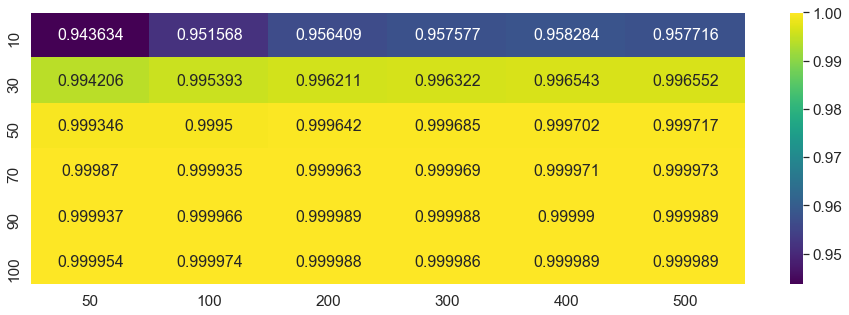

In [37]:
A = np.array(gscv.cv_results_['mean_train_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Seaborn Heatmap on Test Data**

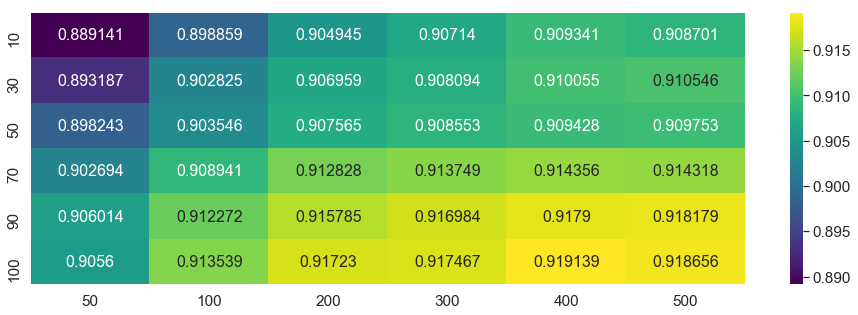

In [38]:
A = np.array(gscv.cv_results_['mean_test_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**ROC Curve**

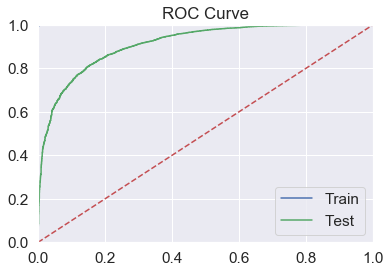

In [36]:
# Plotting roc curve on Train Data
pred_train = RFC_clf.predict_proba(x_train_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_train_tfidf, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = RFC_clf.predict_proba(x_test_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfidf, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[  639  2023]
 [   32 12306]]


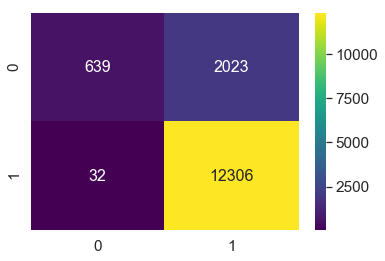

In [34]:
# plotting confusion matrix as heatmap
y_predict = RFC_clf.predict(x_test_tfidf)
cm = confusion_matrix(y_test_tfidf, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**Confusion Matrix on Train Data**

[[ 4521   648]
 [    0 29831]]


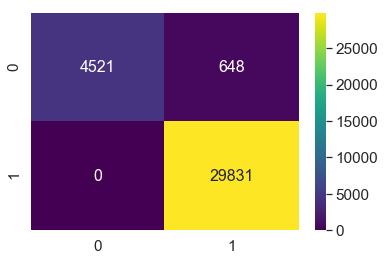

In [35]:
# plotting confusion matrix as heatmap
y_predict = RFC_clf.predict(x_train_tfidf)
cm = confusion_matrix(y_train_tfidf, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

### [3.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [39]:
# Calculate feature importances from decision trees
importances = RFC_clf.feature_importances_

# Sort feature importances in descending order and get their indices
indices = np.argsort(importances)[::-1][:30]

# Get the feature names from the vectorizer
names = tf_idf_vect.get_feature_names()
names = np.array(names)
words = names[indices]
words

array(['disappoint', 'great', 'love', 'return', 'wast', 'worst', 'money',
       'aw', 'horribl', 'terribl', 'would', 'tast', 'bad', 'best',
       'thought', 'good', 'didnt', 'threw', 'refund', 'like', 'disgust',
       'away', 'descript', 'product', 'delici', 'receiv', 'stale',
       'review', 'unfortun', 'mayb'], dtype='<U14')

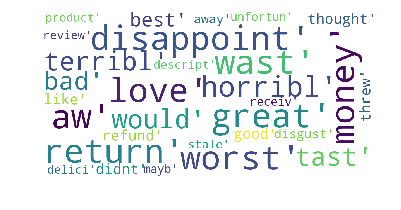

In [40]:
wordcloud = WordCloud(background_color='white',
                      max_font_size=40, 
                      scale=3,
                      random_state=1).generate(str(words))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### [3.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [50]:
# initializing RandomForestClassifier model
RFC = RandomForestClassifier(class_weight='balanced')

# hyperparameter values we need to try on classifier
max_depth = [10, 30, 50, 70, 90, 100]
n_estimators = [50, 100, 200, 300, 400, 500]
param_grid = {'max_depth':max_depth,
              'n_estimators':n_estimators}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 3 fold CV
gscv = GridSearchCV(RFC, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)

gscv.fit(x_train_w2v,y_train_w2v)
print("Best Max Depth Value:",gscv.best_params_['max_depth'])
print("Best No. of Estimators:",gscv.best_params_['n_estimators'])
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best Max Depth Value: 90
Best No. of Estimators: 500
Best ROC AUC Score: 0.88683


In [51]:
# determining optimal depth and base learners
optimal_depth = gscv.best_params_['max_depth']
optimal_estimators = gscv.best_params_['n_estimators']

#training the model using the optimal hyperparameters
RFC_clf = RandomForestClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators)
RFC_clf.fit(x_train_w2v,y_train_w2v)

#predicting the class label using test data 
y_pred = RFC_clf.predict_proba(x_test_w2v)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_w2v, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.883588 ****


**Seaborn Heatmap on Train Data**

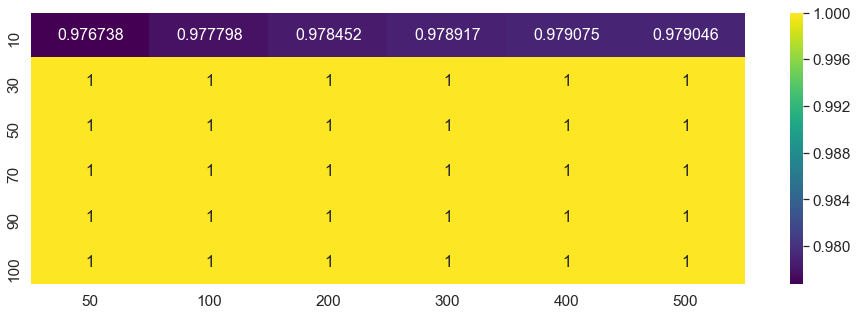

In [57]:
A = np.array(gscv.cv_results_['mean_train_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Seaborn Heatmap on Test Data**

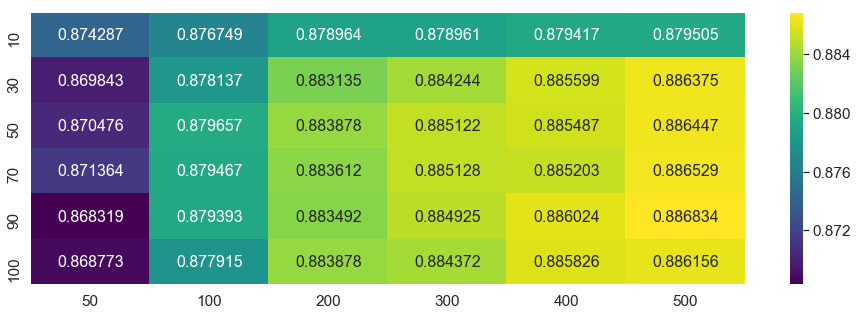

In [56]:
A = np.array(gscv.cv_results_['mean_test_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**ROC Curve**

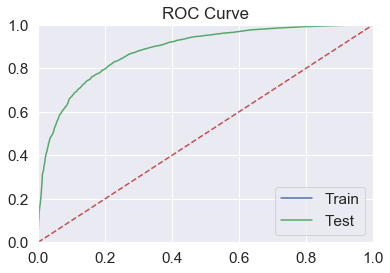

In [54]:
# Plotting roc curve on Train Data
pred_train = RFC_clf.predict_proba(x_train_w2v)[:,1]
fpr, tpr, threshold = roc_curve(y_train_w2v, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = RFC_clf.predict_proba(x_test_w2v)[:,1]
fpr, tpr, threshold = roc_curve(y_test_w2v, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[  778  1884]
 [  186 12152]]


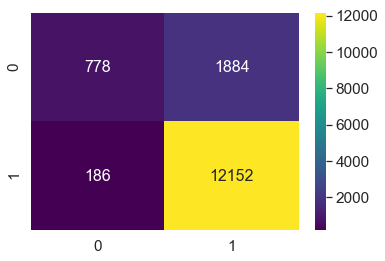

In [52]:
# plotting confusion matrix as heatmap
y_predict = RFC_clf.predict(x_test_w2v)
cm = confusion_matrix(y_test_w2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**Confusion Matrix on Train Data**

[[ 5169     0]
 [    0 29831]]


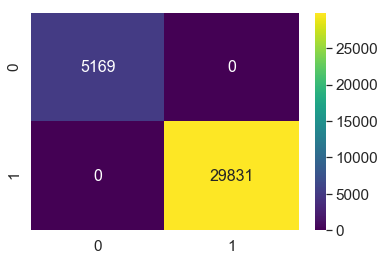

In [53]:
# plotting confusion matrix as heatmap
y_predict = RFC_clf.predict(x_train_w2v)
cm = confusion_matrix(y_train_w2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

### [3.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [28]:
# initializing RandomForestClassifier model
RFC = RandomForestClassifier(class_weight='balanced')

# hyperparameter values we need to try on classifier
max_depth = [10, 30, 50, 70, 90, 100]
n_estimators = [50, 100, 200, 300, 400, 500]
param_grid = {'max_depth':max_depth,
              'n_estimators':n_estimators}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 3 fold CV
gscv = GridSearchCV(RFC, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)

gscv.fit(x_train_tfw2v,y_train_tfw2v)
print("Best Max Depth Value:",gscv.best_params_['max_depth'])
print("Best No. of Estimators:",gscv.best_params_['n_estimators'])
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best Max Depth Value: 50
Best No. of Estimators: 400
Best ROC AUC Score: 0.85953


In [29]:
# determining optimal depth and base learners
optimal_depth = gscv.best_params_['max_depth']
optimal_estimators = gscv.best_params_['n_estimators']

#training the model using the optimal hyperparameters
RFC_clf = RandomForestClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators)
RFC_clf.fit(x_train_tfw2v,y_train_tfw2v)

#predicting the class label using test data 
y_pred = RFC_clf.predict_proba(x_test_tfw2v)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_tfw2v, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.849953 ****


**Seaborn Heatmap on Train Data**

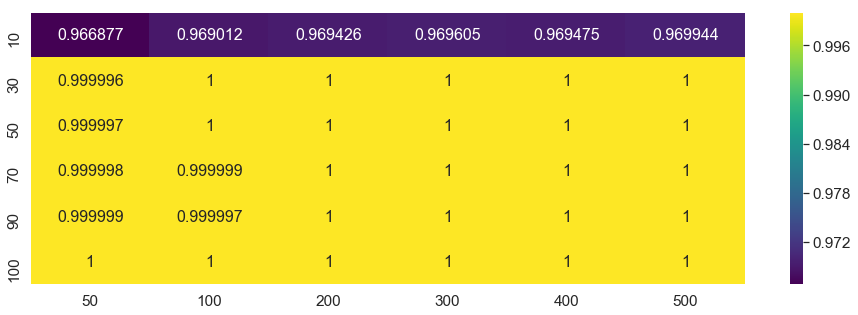

In [34]:
A = np.array(gscv.cv_results_['mean_train_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Seaborn Heatmap on Test Data**

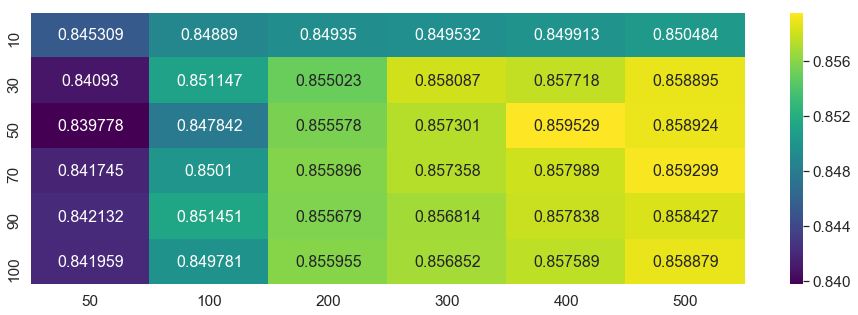

In [33]:
A = np.array(gscv.cv_results_['mean_test_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**ROC Curve**

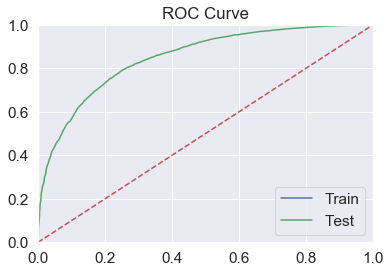

In [32]:
# Plotting roc curve on Train Data
pred_train = RFC_clf.predict_proba(x_train_tfw2v)[:,1]
fpr, tpr, threshold = roc_curve(y_train_tfw2v, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = RFC_clf.predict_proba(x_test_tfw2v)[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfw2v, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[  615  2066]
 [  190 12129]]


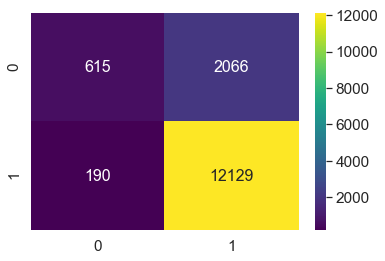

In [30]:
# plotting confusion matrix as heatmap
y_predict = RFC_clf.predict(x_test_tfw2v)
cm = confusion_matrix(y_test_tfw2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**Confusion Matrix on Train Data**

[[ 5272     1]
 [    0 29727]]


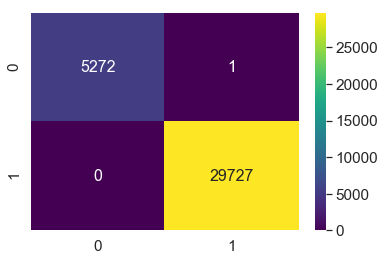

In [31]:
# plotting confusion matrix as heatmap
y_predict = RFC_clf.predict(x_train_tfw2v)
cm = confusion_matrix(y_train_tfw2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

## [4.0] Applying GBDT using XGBOOST

### [4.1.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [14]:
# initializing XGBClassifier model
XGBC = XGBClassifier()

# hyperparameter values we need to try on classifier
max_depth = [2, 3, 5, 6, 7, 8, 9, 10]
n_estimators = [10, 30, 50, 60, 70, 80, 90, 100]
param_grid = {'max_depth':max_depth,
              'n_estimators':n_estimators}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 3 fold CV
gscv = GridSearchCV(XGBC, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)

gscv.fit(x_train_bow,y_train_bow)
print("Best Max Depth Value:",gscv.best_params_['max_depth'])
print("Best No. of Estimators:",gscv.best_params_['n_estimators'])
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best Max Depth Value: 10
Best No. of Estimators: 100
Best ROC AUC Score: 0.90569


In [15]:
# determining optimal depth and base learners
optimal_depth = gscv.best_params_['max_depth']
optimal_estimators = gscv.best_params_['n_estimators']

#training the model using the optimal hyperparameters
XGBC_clf = XGBClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth)
XGBC_clf.fit(x_train_bow, y_train_bow)

#predicting the class label using test data 
y_pred = XGBC_clf.predict_proba(x_test_bow)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_bow, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.913507 ****


**Seaborn Heatmap on Train Data**

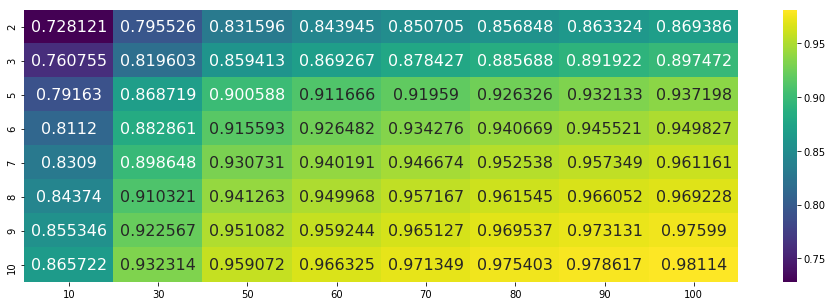

In [16]:
A = np.array(gscv.cv_results_['mean_train_score'])
B = np.reshape(A, (8,8))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Seaborn Heatmap on Test Data**

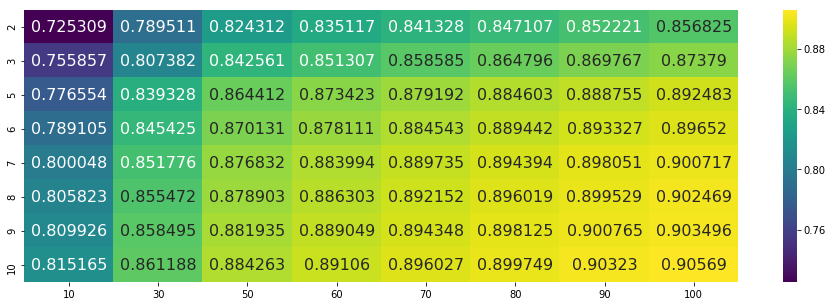

In [17]:
A = np.array(gscv.cv_results_['mean_test_score'])
B = np.reshape(A, (8,8))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Confusion Matrix on Test Data**

[[ 1024  1538]
 [  165 12273]]


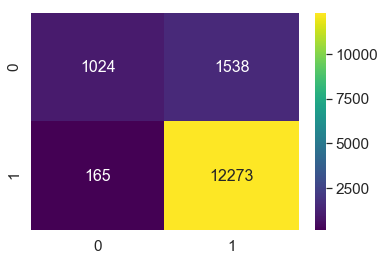

In [18]:
# plotting confusion matrix as heatmap
predicted_y = XGBC_clf.predict(x_test_bow)
cm = confusion_matrix(y_test_bow, predicted_y)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**Confusion Matrix on Train Data**

[[ 3025  2203]
 [   80 29692]]


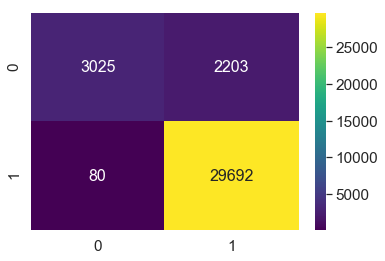

In [19]:
# plotting confusion matrix as heatmap
predicted_y = XGBC_clf.predict(x_train_bow)
cm = confusion_matrix(y_train_bow, predicted_y)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**ROC Curve**

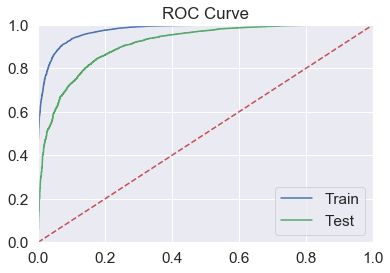

In [20]:
# Plotting roc curve on Train Data
pred_train = XGBC_clf.predict_proba(x_train_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_train_bow, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = XGBC_clf.predict_proba(x_test_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_test_bow, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### Wordcloud of top 20 important features 

In [21]:
# Calculate feature importances from decision trees
importances = XGBC_clf.feature_importances_

# Sort feature importances in descending order and get their indices
indices = np.argsort(importances)[::-1][:30]

# Get the feature names from the vectorizer
names = count_vect.get_feature_names()
names = np.array(names)
words = names[indices]
words

array(['disappoint', 'worst', 'great', 'return', 'delici', 'descript',
       'perfect', 'favorit', 'wast', 'easi', 'excel', 'aw', 'wors',
       'best', 'horribl', 'tasteless', 'mislead', 'awesom', 'trash',
       'terribl', 'satisfi', 'threw', 'lack', 'bland', 'refund',
       'disgust', 'smooth', 'love', 'stuck', 'yummi'], dtype='<U14')

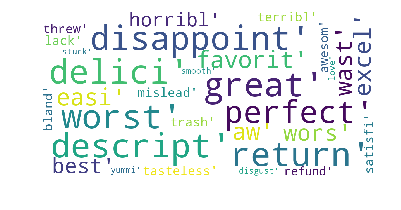

In [22]:
wordcloud = WordCloud(background_color='white',
                      max_font_size=40, 
                      scale=3,
                      random_state=1).generate(str(words))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### [4.1.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [23]:
# initializing XGBClassifier model
XGBC = XGBClassifier()

# hyperparameter values we need to try on classifier
max_depth = [2, 3, 5, 6, 7, 8, 9, 10]
n_estimators = [10, 30, 50, 60, 70, 80, 90, 100]
param_grid = {'max_depth':max_depth,
              'n_estimators':n_estimators}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 3 fold CV
gscv = GridSearchCV(XGBC, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)

gscv.fit(x_train_tfidf,y_train_tfidf)
print("Best Max Depth Value:",gscv.best_params_['max_depth'])
print("Best No. of Estimators:",gscv.best_params_['n_estimators'])
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best Max Depth Value: 10
Best No. of Estimators: 100
Best ROC AUC Score: 0.90605


In [24]:
# determining optimal depth and base learners
optimal_depth = gscv.best_params_['max_depth']
optimal_estimators = gscv.best_params_['n_estimators']

#training the model using the optimal hyperparameters
XGBC_clf = XGBClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth)
XGBC_clf.fit(x_train_tfidf, y_train_tfidf)

#predicting the class label using test data 
y_pred = XGBC_clf.predict_proba(x_test_tfidf)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_tfidf, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.913676 ****


**Seaborn Heatmap on Train Data**

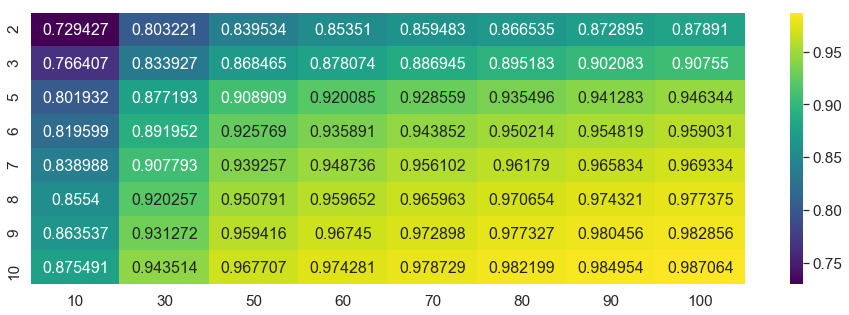

In [25]:
A = np.array(gscv.cv_results_['mean_train_score'])
B = np.reshape(A, (8,8))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Seaborn Heatmap on Test Data**

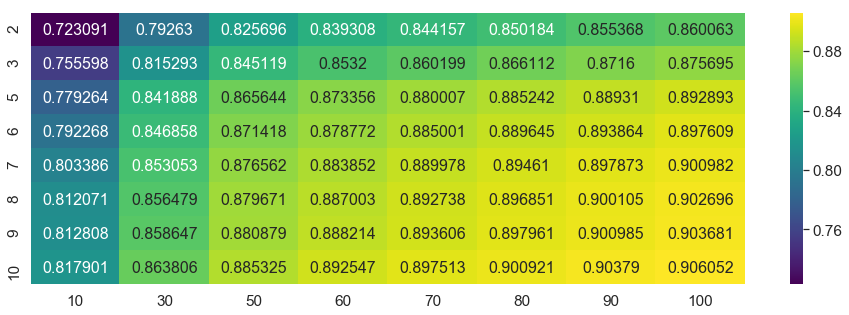

In [26]:
A = np.array(gscv.cv_results_['mean_test_score'])
B = np.reshape(A, (8,8))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Confusion Matrix on Test Data**

[[  996  1566]
 [  161 12277]]


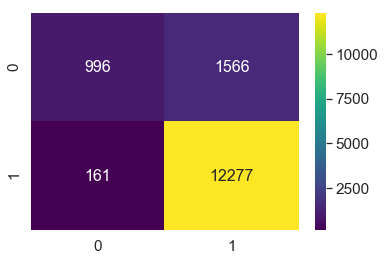

In [27]:
# plotting confusion matrix as heatmap
predicted_y = XGBC_clf.predict(x_test_tfidf)
cm = confusion_matrix(y_test_tfidf, predicted_y)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**Confusion Matrix in Train Data**

[[ 3092  2136]
 [   64 29708]]


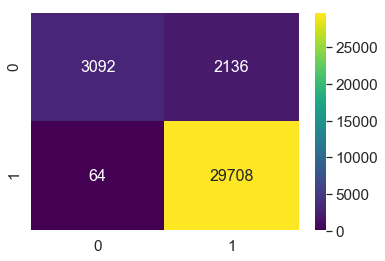

In [28]:
# plotting confusion matrix as heatmap
predicted_y = XGBC_clf.predict(x_train_tfidf)
cm = confusion_matrix(y_train_tfidf, predicted_y)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**ROC Curve**

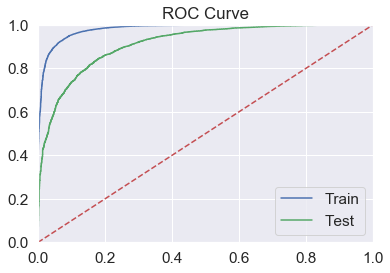

In [30]:
# Plotting roc curve on Train Data
pred_train = XGBC_clf.predict_proba(x_train_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_train_tfidf, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = XGBC_clf.predict_proba(x_test_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfidf, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### Wordcloud of top 20 important features 

In [31]:
# Calculate feature importances from decision trees
importances = XGBC_clf.feature_importances_

# Sort feature importances in descending order and get their indices
indices = np.argsort(importances)[::-1][:30]

# Get the feature names from the vectorizer
names = tf_idf_vect.get_feature_names()
names = np.array(names)
words = names[indices]
words

array(['worst', 'return', 'wast', 'descript', 'disappoint', 'wors',
       'delici', 'perfect', 'horribl', 'easi', 'excel', 'favorit',
       'pictur', 'mislead', 'awesom', 'great', 'threw', 'aw', 'best',
       'refund', 'china', 'disgust', 'satisfi', 'tasti', 'label', 'yuck',
       'smooth', 'addict', 'list', 'stuck'], dtype='<U14')

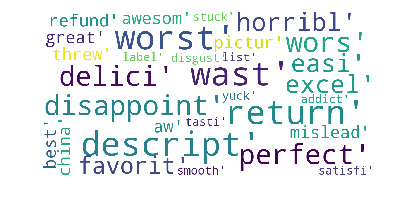

In [32]:
wordcloud = WordCloud(background_color='white',
                      max_font_size=40, 
                      scale=3,
                      random_state=1).generate(str(words))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### [4.1.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [41]:
# initializing XGBClassifier model
XGBC = XGBClassifier()

# hyperparameter values we need to try on classifier
max_depth = [2, 3, 5, 6, 8, 10]
n_estimators = [10, 30, 50, 70, 90, 100]
param_grid = {'max_depth':max_depth,
              'n_estimators':n_estimators}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 3 fold CV
gscv = GridSearchCV(XGBC, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)

gscv.fit(x_train_w2v,y_train_w2v)
print("Best Max Depth Value:",gscv.best_params_['max_depth'])
print("Best No. of Estimators:",gscv.best_params_['n_estimators'])
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best Max Depth Value: 6
Best No. of Estimators: 100
Best ROC AUC Score: 0.89078


In [42]:
# determining optimal depth and base learners
optimal_depth = gscv.best_params_['max_depth']
optimal_estimators = gscv.best_params_['n_estimators']

#training the model using the optimal hyperparameters
XGBC_clf = XGBClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth)
XGBC_clf.fit(x_train_w2v, y_train_w2v)

#predicting the class label using test data 
y_pred = XGBC_clf.predict_proba(x_test_w2v)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_w2v, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.889072 ****


**Seaborn Heatmap on Train Data**

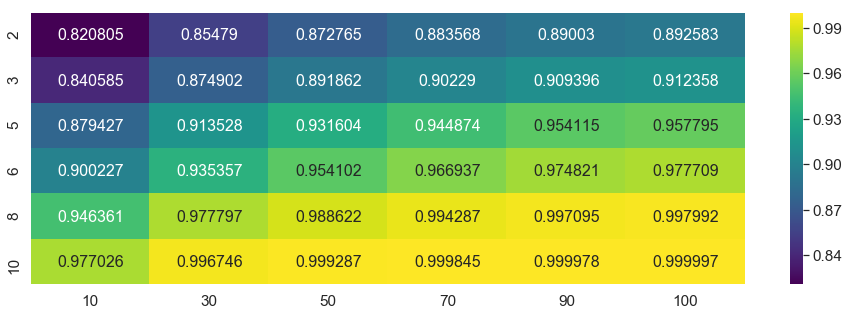

In [43]:
A = np.array(gscv.cv_results_['mean_train_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Seaborn Heatmap on Test Data**

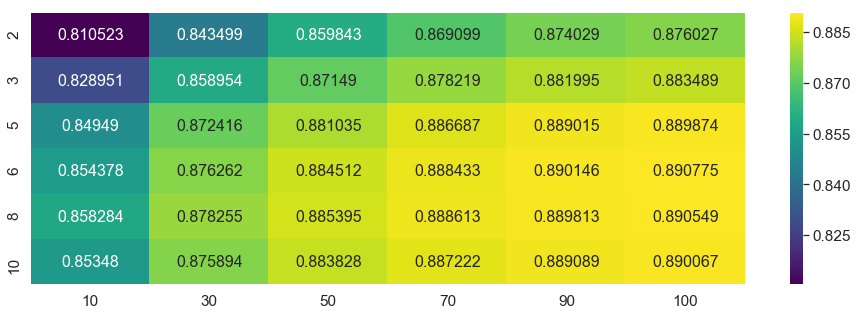

In [44]:
A = np.array(gscv.cv_results_['mean_test_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Confusion Matrix on Test Data**

[[ 1151  1411]
 [  440 11998]]


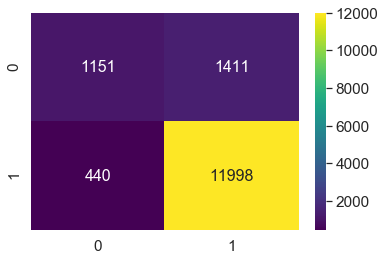

In [47]:
# plotting confusion matrix as heatmap
predicted_y = XGBC_clf.predict(x_test_w2v)
cm = confusion_matrix(y_test_w2v, predicted_y)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**Confusion Matrix on Train Data**

[[ 3229  1999]
 [  416 29356]]


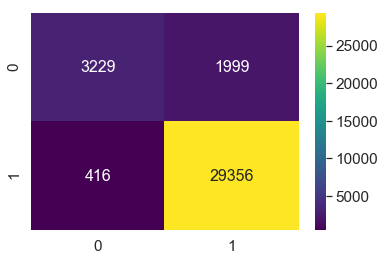

In [49]:
# plotting confusion matrix as heatmap
predicted_y = XGBC_clf.predict(x_train_w2v)
cm = confusion_matrix(y_train_w2v, predicted_y)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**ROC Curve**

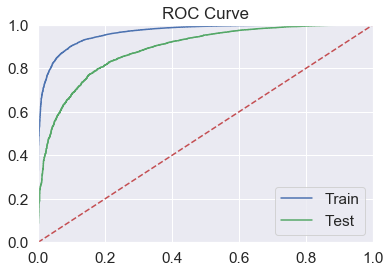

In [50]:
# Plotting roc curve on Train Data
pred_train = XGBC_clf.predict_proba(x_train_w2v)[:,1]
fpr, tpr, threshold = roc_curve(y_train_tfidf, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = XGBC_clf.predict_proba(x_test_w2v)[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfidf, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### [4.1.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [57]:
# initializing XGBClassifier model
XGBC = XGBClassifier()

# hyperparameter values we need to try on classifier
max_depth = [2, 3, 5, 6, 8, 10]
n_estimators = [10, 30, 50, 70, 90, 100]
param_grid = {'max_depth':max_depth,
              'n_estimators':n_estimators}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 3 fold CV
gscv = GridSearchCV(XGBC, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, return_train_score=True)

gscv.fit(x_train_tfw2v,y_train_tfw2v)
print("Best Max Depth Value:",gscv.best_params_['max_depth'])
print("Best No. of Estimators:",gscv.best_params_['n_estimators'])
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best Max Depth Value: 6
Best No. of Estimators: 100
Best ROC AUC Score: 0.86542


In [58]:
# determining optimal depth and base learners
optimal_depth = gscv.best_params_['max_depth']
optimal_estimators = gscv.best_params_['n_estimators']

#training the model using the optimal hyperparameters
XGBC_clf = XGBClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth)
XGBC_clf.fit(x_train_tfw2v, y_train_tfw2v)

#predicting the class label using test data 
y_pred = XGBC_clf.predict_proba(x_test_tfw2v)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_tfw2v, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.863633 ****


**Seaborn Heatmap on Train Data**

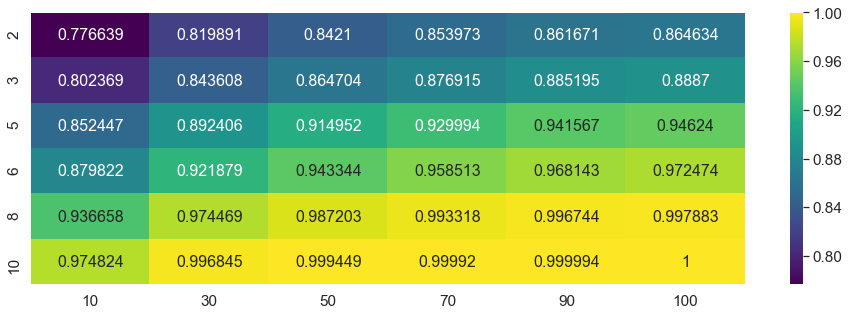

In [59]:
A = np.array(gscv.cv_results_['mean_train_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Seaborn Heatmap on Test Data**

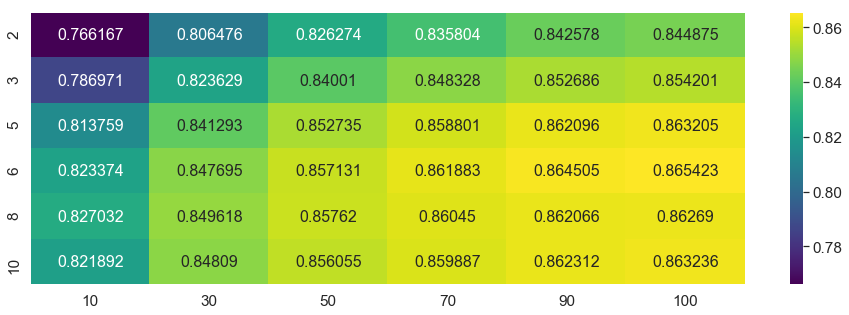

In [60]:
A = np.array(gscv.cv_results_['mean_test_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=n_estimators)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

**Confusion Matrix on Test Data**

[[  931  1631]
 [  403 12035]]


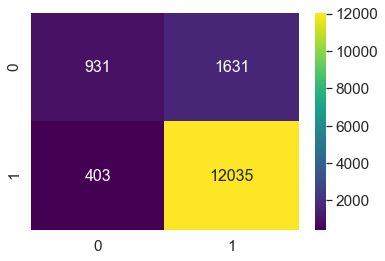

In [61]:
# plotting confusion matrix as heatmap
predicted_y = XGBC_clf.predict(x_test_tfw2v)
cm = confusion_matrix(y_test_tfidf, predicted_y)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**Confusion Matrix on Train Data**

[[ 2804  2424]
 [  392 29380]]


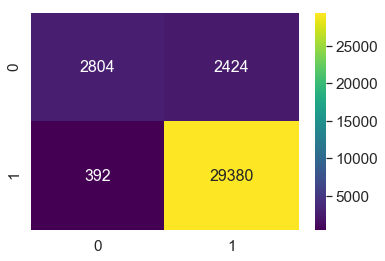

In [62]:
# plotting confusion matrix as heatmap
predicted_y = XGBC_clf.predict(x_train_tfw2v)
cm = confusion_matrix(y_train_tfidf, predicted_y)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

**ROC Curve**

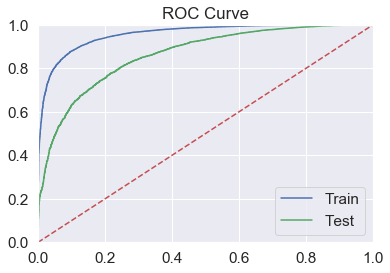

In [63]:
# Plotting roc curve on Train Data
pred_train = XGBC_clf.predict_proba(x_train_tfw2v)[:,1]
fpr, tpr, threshold = roc_curve(y_train_tfidf, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = XGBC_clf.predict_proba(x_test_tfw2v)[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfidf, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## [5.0] Conclusion

In [14]:
t=PrettyTable()
t.field_names = ['Vectorizer', 'max_depth', 'n_estimators', 'Train AUC', 'Test AUC']
t.add_row(['BOW', '100', '500', '0.91873', '0.90145'])
t.add_row(['TFIDF', '100', '400', '0.91914', '0.91321'])
t.add_row(['Avg W2V', '90', '500', '0.88683', '0.88358'])
t.add_row(['TFIDF-W2V', '50', '400', '0.85953', '0.84995'])
print('***** Random Forests *****')
print(t)

***** Random Forests *****
+------------+-----------+--------------+-----------+----------+
| Vectorizer | max_depth | n_estimators | Train AUC | Test AUC |
+------------+-----------+--------------+-----------+----------+
|    BOW     |    100    |     500      |  0.91873  | 0.90145  |
|   TFIDF    |    100    |     400      |  0.91914  | 0.91321  |
|  Avg W2V   |     90    |     500      |  0.88683  | 0.88358  |
| TFIDF-W2V  |     50    |     400      |  0.85953  | 0.84995  |
+------------+-----------+--------------+-----------+----------+


In [65]:
t=PrettyTable()
t.field_names = ['Vectorizer', 'max_depth', 'n_estimators', 'Train AUC', 'Test AUC']
t.add_row(['BOW', '10', '100', '0.90569', '0.91350'])
t.add_row(['TFIDF', '10', '100', '0.90605', '0.91367'])
t.add_row(['Avg W2V', '6', '100', '0.89078', '0.88907'])
t.add_row(['TFIDF-W2V', '6', '100', '0.86542', '0.86363'])
print('***** XGBoost *****')
print(t)

***** XGBoost *****
+------------+-----------+--------------+-----------+----------+
| Vectorizer | max_depth | n_estimators | Train AUC | Test AUC |
+------------+-----------+--------------+-----------+----------+
|    BOW     |     10    |     100      |  0.90569  | 0.91350  |
|   TFIDF    |     10    |     100      |  0.90605  | 0.91367  |
|  Avg W2V   |     6     |     100      |  0.89078  | 0.88907  |
| TFIDF-W2V  |     6     |     100      |  0.86542  | 0.86363  |
+------------+-----------+--------------+-----------+----------+
